# Convolutional networks
This file shows how to programm and setup a convolutional neural network using Tensorflow.
Steps to do:
	- download and import data
    - preprocess data (structure data into training, validation, test set etc)
    - create mini-batches of data for training
    - setup or import a neural network model (tf.Graph)
    - define loss function
    - train neural network
    - evaluate neural network
    - provide an inference function for predicting labels of test data set (unknown data)
    - visualize neural network data with tensorflow and here in jupyter notebook

In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import input_queues as iq
import plot_helpers as plt_help
import cnn_helpers as chlp


__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

__all__ = ['predict']

# make only 'gpu:0' visible, so that only one gpu is used not both, see also
# https://github.com/tensorflow/tensorflow/issues/5066
# https://github.com/tensorflow/tensorflow/issues/3644#issuecomment-237631171
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def predict(image, path_inference_graph, checkpoint_path,
            nodes_name_dict, plot_inference_graph=False):
    """
    :param image:
    :type image:
    :param path_inference_graph: path to inference graph (graph without 
        'training' ops)
    :type path_inference_graph: str
    :param checkpoint_path: path to model parameters (checkpoint files
        e.g. 'logs/2/tfmodel-5')
    :type checkpoint_path: str
    :param nodes_name_dict: dictionary that contains name of input, albedo and 
        shading output in form {'input': '', 
                                'output_albedo': '',
                                'output_shading': ''}
    :type nodes_name_dict: dict
    :param plot_inference_graph: flag, True if inference graph should be 
        plotted (default: False).
    :type plot_inference_graph: boolean

    :return: prediction albedo layer, prediction shading layer
    """
    # clear default graph:
    tf.reset_default_graph()
     
    # import meta (inference) graph:
    meta_graph = tf.train.import_meta_graph(path_inference_graph,
                                            clear_devices=True)
    # save default graph in variable:
    graph = tf.get_default_graph()
    if plot_inference_graph:
        # plot imported inference graph:
        plt_help.show_graph(graph.as_graph_def())

    ############################################################################
    ############################################################################
    # defining input/output nodes:

    # lets get the input
    x = graph.get_tensor_by_name(name=nodes_name_dict['input'])

    # bool variable that indicates if we are in training mode (training=True) or
    # valid/test mode (training=False) this indicator is important if dropout 
    # or/and batch normalization is used.
    try:
        # try importing training node (is needed for models that use batch 
        # normalization etc.)
        training = graph.get_tensor_by_name(name='is_training:0')
    except KeyError:
        # elsewise just define a placeholder wich is used as dummy variable
        # and won't be used later:
        training = tf.placeholder(dtype=tf.bool, name='is_training')

    # get graph output nodes:
    y_albedo_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_albedo'])
    y_shading_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_shading'])

    # y_albedo_pred = tf.clip_by_value(t=y_albedo, clip_value_min=0, 
    #                                  clip_value_max=1, 
    #                                  name='0_1_clipping_albedo')
    # y_shading_pred = tf.clip_by_value(t=y_shading, clip_value_min=0,
    #                                   clip_value_max=1, 
    #                                   name='0_1_clipping_shading')

    ############################################################################
    ############################################################################
    # making prediction:

    with tf.Session() as sess:
        # Restore variables from disk.
        meta_graph.restore(sess, checkpoint_path)
        # make predictions:
        feed_dict = {x: image, 
                     training: False}

        pred_alb, pred_shad = sess.run([y_albedo_pred, y_shading_pred],
                                       feed_dict=feed_dict)
    
    return pred_alb, pred_shad

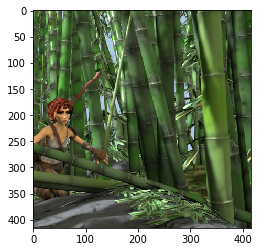

In [2]:
# testing data set:
data_dir = '/usr/udo/data/'
file_sintel = 'data_sintel_shading_test.csv'
df_test_sintel = pd.read_csv(data_dir + file_sintel, sep=',', header=None,
                             names=['img', 'alb', 'shad', 'invalid'])
# compolete image paths:
df_test_sintel = data_dir + df_test_sintel

# # get one test image path (and its ground truth labels):
# df_image_paths_sintel = df_test_sintel.loc[[12], ['img', 'alb', 'shad']]

# import one image:
lst = iq.next_batch_sintel(deq=df_test_sintel,
                           output_shape=[32 * 13, 32 * 13, 3],
                           is_scale=False,
                           is_flip=False,
                           is_rotated=False,
                           norm=True)
img_sintel_b, alb_sintel_b, shad_sintel_b, inv_sintel_b = lst
plt.imshow(img_sintel_b[0])

In [3]:
file_iiw = 'data_iiw_test.csv'
df_test_iiw = pd.read_csv(filepath_or_buffer=data_dir + file_iiw, 
                          sep=',', header=None,
                          names=['img', 'json_label'])
# complete image paths:
df_test_iiw = data_dir + df_test_iiw
# # get one test image path (and its ground truth labels):
# df_image_paths_iiw = df_test_iiw.loc[[1], ['img', 'json_label']]



invalid image height 294


/home/users/dehm/image_decomposition/input_queues.py:794: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['x'] = (df_point_crop['x'] * img.shape[1] - x_start) / output_shape[1]
/home/users/dehm/image_decomposition/input_queues.py:795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['y'] = (df_point_crop['y'] * img.shape[0] - y_start) / output_shape[0]
/home/users/dehm/image_decomposition/input_queues.py:842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

invalid image width 304
invalid image height 316
invalid image height 289
invalid image width 289
invalid image height 289
invalid image height 289
invalid image width 317
invalid image height 319
invalid image height 265
invalid image width 289
invalid image height 288
invalid image height 288
invalid image height 289
invalid image width 289
invalid image height 288
invalid image width 283
invalid image width 288
invalid image width 288
invalid image width 288
invalid image width 289
invalid image height 288
invalid image width 288
invalid image width 307
invalid image width 307
invalid image width 293
invalid image width 311
invalid image width 307
invalid image height 288
invalid image height 306
invalid image height 288
invalid image height 295
invalid image width 319
invalid image height 308
invalid image height 288
invalid image height 288
invalid image width 310
invalid image height 287
invalid image width 288
invalid image width 288
invalid image width 288
invalid image width 2

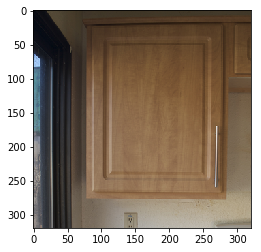

In [ ]:
# import one image:
df_iiw, images_iiw, images_original_iiw, js_labels_iiw, js_labels_original_iiw = iq.next_batch_iiw(deq=df_test_iiw.loc[:100,:],
                                                                                                   output_shape=[320, 320, 3],
                                                                                                   norm=True)
plt.imshow(images_iiw[0])

In [ ]:
# slim_vgg16_narihira2015/...:
# nodes_name_dict = {'input': 'input:0',
#                    'output_albedo': 'scale2/deconv6_s2_albedo/BiasAdd:0',
#                    'output_shading': 'scale2/deconv6_s2_shading/BiasAdd:0'}
# .../norm_berhu:
# params = {'path_inference_graph': 'models/slim/graphs/vgg16_narihira2015/tfmodel_inference.meta', # e.g. 'logs/2/tfmodel-5' or None
#           'checkpoint_path': 'logs/slim_vgg16_narihira2015/norm_berhu/2/tfmodel-2100',
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': True,
#           'plot_inference_graph': True}

# .../no_norm_berhu:
# params = {'path_inference_graph': 'models/slim/graphs/vgg16_narihira2015/tfmodel_inference.meta', # e.g. 'logs/2/tfmodel-5' or None
#           'checkpoint_path': 'logs/slim_vgg16_narihira2015/no_norm_berhu/1/tfmodel-4300',
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': False,
#           'plot_inference_graph': False}

# .../norm_l1:
# params = {'path_inference_graph': 'models/slim/graphs/vgg16_narihira2015/tfmodel_inference.meta', # e.g. 'logs/2/tfmodel-5' or None
#           'checkpoint_path': 'logs/slim_vgg16_narihira2015/norm_l1/2/tfmodel-2100',
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': True,
#           'plot_inference_graph': False}

# .../no_norm_l1:
# params = {'path_inference_graph': 'models/slim/graphs/vgg16_narihira2015/tfmodel_inference.meta', # e.g. 'logs/2/tfmodel-5' or None
#           'checkpoint_path': 'logs/slim_vgg16_narihira2015/no_norm_l1/1/tfmodel-4300',
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': False,
#           'plot_inference_graph': False}

# slim_vgg16/norm_l1:
# params = {'path_inference_graph': 'models/slim/graphs/vgg16/tfmodel_inference.meta',
#           'checkpoint_path': 'logs/slim_vgg16/norm_l1/1/tfmodel-2100',
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': True,
#           'plot_inference_graph': False}


# slim_resnet_v1_50_deconv_decoder/...:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'decoder/deconv7_albedo/BiasAdd:0',
                   'output_shading': 'decoder/deconv7_shading/BiasAdd:0'}
# .../norm_l1:
params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50/tfmodel_inference.meta',
          'checkpoint_path': 'logs/slim_resnet_v1_50_deconv_decoder/norm_l1/1/tfmodel-3200',
          'nodes_name_dict': nodes_name_dict,
          'plot_inference_graph': False}

# # .../no_norm_l1:
# params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50/tfmodel_inference.meta',
#           'checkpoint_path': 'logs/slim_resnet_v1_50_deconv_decoder/no_norm_l1/1/tfmodel-2100',
#           'image_shape': [32 * m_height, 32 * m_width, 3],
#           'nodes_name_dict': nodes_name_dict,
#           'norm': False,
#           'plot_inference_graph': True}


pred_alb, pred_shad = predict(image=img_sintel_b, **params)

INFO:tensorflow:Restoring parameters from logs/slim_resnet_v1_50_deconv_decoder/norm_l1/1/tfmodel-3200


In [ ]:
valid_mask = chlp.get_valid_pixels(image=img_sintel_b, 
                                   invalid_mask=inv_sintel_b)
d = {'label_albedo': alb_sintel_b,
     'label_shading': shad_sintel_b,
     'prediction_albedo': pred_alb, 
     'prediction_shading': pred_shad,
     'valid_mask': valid_mask}

loss_dict = {'berhu': chlp.sintel_loss_fct(**d, **{'loss_type': 'berhu', 
                                                   'lambda_': None}),
             'l1': chlp.sintel_loss_fct(**d, **{'loss_type': 'l1',
                                                'lambda_': None}),
             'l2': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2', 
                                                'lambda_': 0}),
             'l2_inv': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2',
                                                    'lambda_': 1}),
             'l2_avg': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2',
                                                    'lambda_': 0.5})
            }
with tf.Session() as sess:
    losses_sintel = sess.run(loss_dict)
    
losses_sintel

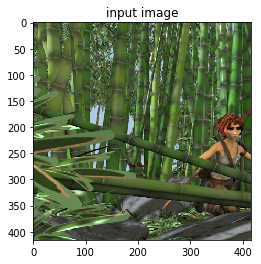

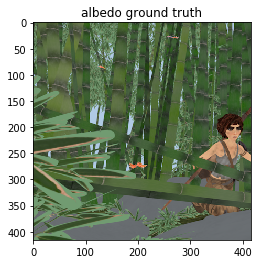

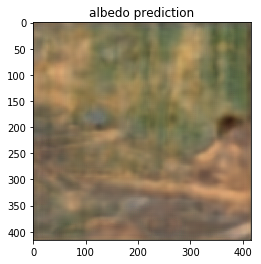

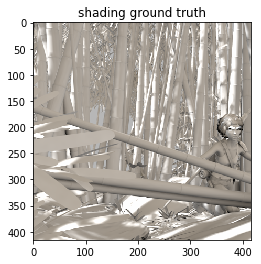

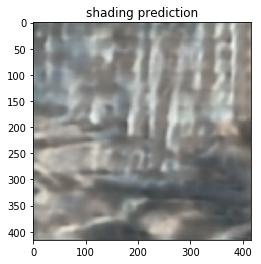

In [7]:
#print(f'path to (raw) image: {path_te}')
i = 0  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[img_sintel_b[i], 
                             alb_sintel_b[i], 
                             pred_alb[i], 
                             shad_sintel_b[i], 
                             pred_shad[i]],
                     titles=['input image', 
                             'albedo ground truth', 
                             'albedo prediction', 
                             'shading ground truth', 
                             'shading prediction'])

In [ ]:
# slim_resnet_v1_50_deconv_decoder/...:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'decoder/deconv7_albedo/BiasAdd:0',
                   'output_shading': 'decoder/deconv7_shading/BiasAdd:0'}
# .../norm_l1:
params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50/tfmodel_inference.meta',
          'checkpoint_path': 'logs/iiw/norm_mhdl/1/tfmodel-1300',
          'nodes_name_dict': nodes_name_dict,
          'plot_inference_graph': False}

pred_alb, pred_shad = predict(image=images_iiw, **params)
################################################################################



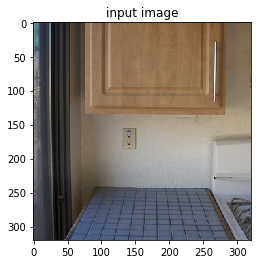

ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

In [7]:
#print(f'path to (raw) image: {path_te}')
i = 0  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[images_iiw[i], 
                             pred_alb[i], 
                             pred_shad[i]],
                     titles=['input image', 
                             'albedo prediction', 
                             'shading prediction'])

In [10]:
df_iiw[['batch_nr', 'y2', 'x2']].values

array([[1, 98, 247],
       [1, 195, 253],
       [1, 183, 172],
       ..., 
       [100, 280, 156],
       [100, 268, 187],
       [100, 231, 113]], dtype=object)

In [12]:
lambda_loss = 1.0
point1 = tf.placeholder(dtype=tf.int32, name='point1')
point2 = tf.placeholder(dtype=tf.int32, name='point2')
# get the human darker labels:
human_labels = tf.placeholder(dtype=tf.int32, name='human_labels')
# list of weights/darker scores:
darker_weights = tf.placeholder(dtype=tf.float32, name='darker_weights')

losses_iiw = chlp.iiw_loss_fct(input_image=tf.Variable(images_iiw, dtype=tf.float32),
                               prediction_albedo=tf.Variable(pred_alb, dtype=tf.float32),
                               prediction_shading=tf.Variable(pred_shad, dtype=tf.float32),
                               albedo_comp_point1=point1,
                               albedo_comp_point2=point2,
                               albedo_comp_human_labels=human_labels,
                               albedo_comp_weights=darker_weights,
                               albedo_comp_delta=0.1,
                               lambda_=lambda_loss)
# losses_iiw = chlp.iiw_loss_fct(input_image=images_iiw,
#                                prediction_albedo=pred_alb,
#                                prediction_shading=pred_shad,
#                                albedo_comp_point1=df_iiw[['batch_nr', 'y1', 'x1']].values,
#                                albedo_comp_point2=df_iiw[['batch_nr', 'y2', 'x2']].values,
#                                albedo_comp_human_labels=df_iiw['darker'].values,
#                                albedo_comp_weights=df_iiw['darker_score'].values,
#                                albedo_comp_delta=0.1,
#                                lambda_=lambda_loss)

loss_dict = {'l1_mhdl': losses_iiw[0],
             'l1_mwhdl': losses_iiw[1],
             'l2_mhdl': losses_iiw[2],
             'l2_mwhdl': losses_iiw[3],
             'l1': losses_iiw[4],
             'l2': losses_iiw[5],
             'mhdl': losses_iiw[6],
             'mwhdl': losses_iiw[7]}

In [13]:
with tf.Session() as sess:
    fd = {point1: df_iiw[['batch_nr', 'y1', 'x1']].values,
          point2: df_iiw[['batch_nr', 'y2', 'x2']].values,
          human_labels: df_iiw['darker'].values,
          darker_weights: df_iiw['darker_score'].values
         }
    # run optimization step:
    losses_iiw_results = sess.run(loss_dict, feed_dict=fd)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]

Caused by op 'Variable/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-d196efa5af63>", line 9, in <module>
    losses_iiw = chlp.iiw_loss_fct(input_image=tf.Variable(images_iiw, dtype=tf.float32),
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 330, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1400, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/users/dehm/.venvs/tf_1-3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]


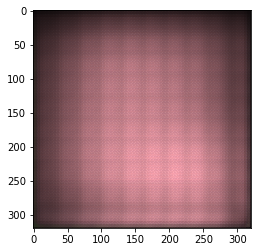

In [15]:
plt.imshow((pred_alb[0] - pred_alb[0].min())/ (pred_alb[0].max()-pred_alb[0].min()))

In [17]:
# !tensorboard --logdir ./logs/camp/2

## resizing an image

In [7]:
import scipy as sp

In [10]:
images[0].reshape(params['image_shape']).shape

(416, 416, 3)

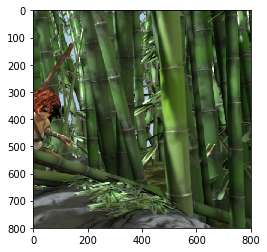

In [16]:
plt.imshow(sp.misc.imresize(arr=images[0].reshape(params['image_shape']),
                 size=(800, 800, 3), interp='bilinear', mode=None))

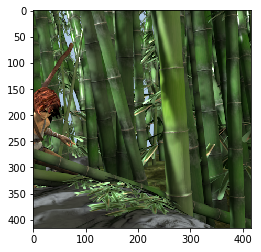

In [17]:
plt.imshow(images[0].reshape(params['image_shape']))